# IESTI01_KWS_Sound_Classification
- TinyML - Edge Impulse Model Training analysis 
- M.Rovai @20Nov2021

In [23]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.fftpack
import librosa
import librosa.display
import IPython.display

## Analizyng Audio raw sample

- From Edge Impulse Studio `Data Aquisition - Export Data` Tab, download to your computer a zip file with the .wav raw data captured.
- Upload on /content one (or more) .wav samples

In [9]:
!ls /content

sample_data					  x_train.npy
unifei.29js37tq.ingestion-fdb45cc77-7dhh9.s1.wav  y_train.npy


In [12]:
sound_path = '/content/unifei.29js37tq.ingestion-fdb45cc77-7dhh9.s1.wav'

In [17]:
audio, sample_rate = librosa.load(sound_path, sr=16_000)
sample_rate

16000

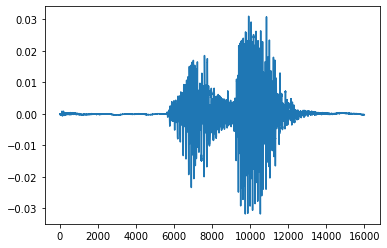

In [18]:
plt.plot(audio);

In [20]:
IPython.display.Audio(data=audio, rate=sample_rate)

In [26]:
 def fft(data, N=sample_rate, title = ''):  
    yf = scipy.fftpack.fft(data)
    plt.plot(2.0/N * np.abs(yf[:N//2]))
    plt.xlabel('frequency [Hz]')
    plt.ylabel('amp')
    plt.grid(True)
    plt.title(title+' sample - Frequency Components')
    plt.show();

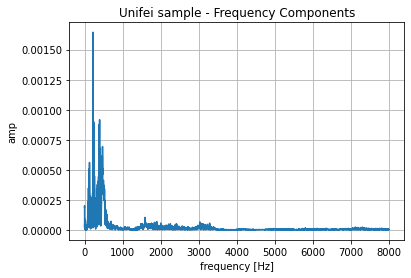

In [27]:
fft(audio, title = 'Unifei')

In [37]:
 def spectogram(data, NFFT=256, Fs=sample_rate, title=''):
    plt.specgram(data, NFFT, Fs)
    plt.xlabel('time (s)')
    plt.ylabel('frequency [Hz]')
    plt.title(title+' sample - Spectogram')
    plt.show();

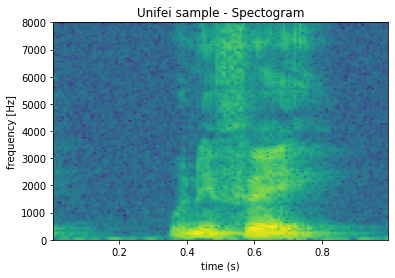

In [38]:
spectogram(audio, title='Unifei')

## Analysing Edge Impulse Model Training

Download the data - after extracting features through a processing block - so we can train a machine learning model.

In [61]:
import numpy as np
import requests

API_KEY = 'ei_98b6c42cd610ed6b1f4354ff1d2b8ccb2a0bc1694b165bfda5fa2ff0ea93bea5'

def download_data(url):
    response = requests.get(url, headers={'x-api-key': API_KEY})
    if response.status_code == 200:
        return response.content
    else:
        print(response.content)
        raise ConnectionError('Could not download data file')

X = download_data('https://studio.edgeimpulse.com/v1/api/38744/training/5/x')
Y = download_data('https://studio.edgeimpulse.com/v1/api/38744/training/5/y')


Store the data in a temporary file, and load it back through Numpy.

In [62]:
with open('x_train.npy', 'wb') as file:
    file.write(X)
with open('y_train.npy', 'wb') as file:
    file.write(Y)
X = np.load('x_train.npy')
Y = np.load('y_train.npy')[:,0]

In [3]:
X.shape, Y.shape

((253, 650), (253,))

In [4]:
image = X[0]
img_length = image.shape[0]
img_length

650

In [5]:
columns = 13
rows = int(img_length / columns)
image = np.reshape(image, (rows, columns))
image.shape

(50, 13)

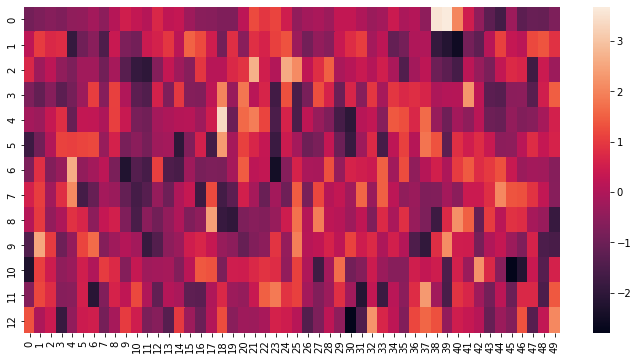

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize=(12,6))
sns.heatmap(image.T);


Define our labels and split the data up in a test and training set:

In [63]:
import sys, os, random
import tensorflow as tf
from sklearn.model_selection import train_test_split

# Set random seeds for repeatable results
RANDOM_SEED = 3
random.seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)
tf.random.set_seed(RANDOM_SEED)

classes_values = [ "iesti", "silence", "unifei" ]
classes = len(classes_values)

Y = tf.keras.utils.to_categorical(Y - 1, classes)

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=1)

input_length = X_train[0].shape[0]

train_dataset = tf.data.Dataset.from_tensor_slices((X_train, Y_train))
validation_dataset = tf.data.Dataset.from_tensor_slices((X_test, Y_test))

In [64]:
def get_reshape_function(reshape_to):
    def reshape(image, label):
        return tf.reshape(image, reshape_to), label
    return reshape

In [65]:
from tensorflow.keras.callbacks import EarlyStopping
early_stop = EarlyStopping(monitor='val_loss', 
                           mode='min', 
                           verbose=1, 
                           patience=20)

callbacks = [early_stop]

Train the model:

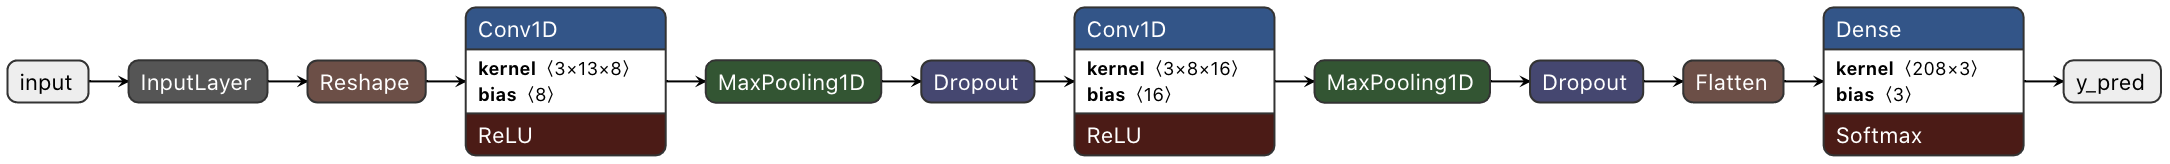

In [66]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, InputLayer, Dropout, Conv1D, Conv2D, Flatten, Reshape, MaxPooling1D, MaxPooling2D, BatchNormalization
from tensorflow.keras.optimizers import Adam

# model architecture
model = Sequential()
model.add(Reshape((int(input_length / 13), 13), input_shape=(input_length, )))
model.add(Conv1D(8, kernel_size=3, activation='relu', padding='same'))
model.add(MaxPooling1D(pool_size=2, strides=2, padding='same'))
model.add(Dropout(0.25))
model.add(Conv1D(16, kernel_size=3, activation='relu', padding='same'))
model.add(MaxPooling1D(pool_size=2, strides=2, padding='same'))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(classes, activation='softmax', name='y_pred'))

model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 reshape_3 (Reshape)         (None, 50, 13)            0         
                                                                 
 conv1d_6 (Conv1D)           (None, 50, 8)             320       
                                                                 
 max_pooling1d_6 (MaxPooling  (None, 25, 8)            0         
 1D)                                                             
                                                                 
 dropout_6 (Dropout)         (None, 25, 8)             0         
                                                                 
 conv1d_7 (Conv1D)           (None, 25, 16)            400       
                                                                 
 max_pooling1d_7 (MaxPooling  (None, 13, 16)           0         
 1D)                                                  

In [67]:
LR = 0.001
BS = 32
EPOCHS = 200

In [68]:
# this controls the learning rate
opt = Adam(lr=LR, beta_1=0.9, beta_2=0.999)
# this controls the batch size, or you can manipulate the tf.data.Dataset objects yourself
BATCH_SIZE = BS
train_dataset = train_dataset.batch(BATCH_SIZE, drop_remainder=False)
validation_dataset = validation_dataset.batch(BATCH_SIZE, drop_remainder=False)

# train the neural network
model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
history = model.fit(train_dataset, epochs=EPOCHS, validation_data=validation_dataset, verbose=2, callbacks=callbacks)


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 1/200
7/7 - 1s - loss: 1.7240 - accuracy: 0.3614 - val_loss: 1.1605 - val_accuracy: 0.3529 - 798ms/epoch - 114ms/step
Epoch 2/200
7/7 - 0s - loss: 1.3347 - accuracy: 0.3416 - val_loss: 1.1786 - val_accuracy: 0.3529 - 31ms/epoch - 4ms/step
Epoch 3/200
7/7 - 0s - loss: 1.2614 - accuracy: 0.4059 - val_loss: 1.1453 - val_accuracy: 0.3725 - 33ms/epoch - 5ms/step
Epoch 4/200
7/7 - 0s - loss: 1.1778 - accuracy: 0.3911 - val_loss: 1.0771 - val_accuracy: 0.4314 - 34ms/epoch - 5ms/step
Epoch 5/200
7/7 - 0s - loss: 1.1896 - accuracy: 0.3960 - val_loss: 1.0306 - val_accuracy: 0.4118 - 36ms/epoch - 5ms/step
Epoch 6/200
7/7 - 0s - loss: 1.1398 - accuracy: 0.3861 - val_loss: 1.0116 - val_accuracy: 0.4706 - 40ms/epoch - 6ms/step
Epoch 7/200
7/7 - 0s - loss: 1.0836 - accuracy: 0.4356 - val_loss: 1.0121 - val_accuracy: 0.4510 - 38ms/epoch - 5ms/step
Epoch 8/200
7/7 - 0s - loss: 1.0157 - accuracy: 0.4604 - val_loss: 1.0027 - val_accuracy: 0.4902 - 37ms/epoch - 5ms/step
Epoch 9/200
7/7 - 0s - loss: 

In [69]:
def get_test_accuracy(model, x_test, y_test):
    """Test model classification accuracy"""
    test_loss, test_acc = model.evaluate(x=x_test, y=y_test, verbose=0)
    print('accuracy: {acc:0.3f}'.format(acc=test_acc))

def plot_result(history, res= 'loss'):
    plt.plot(history.history[res])
    plt.plot(history.history['val_'+res])
    plt.title(res+' vs. epochs')
    plt.ylabel(res)
    plt.xlabel('Epoch')
    if res == 'loss':
        plt.legend(['Training', res], loc='upper right')
    else:
        plt.legend(['Training', res], loc='lower right')
    plt.show() 


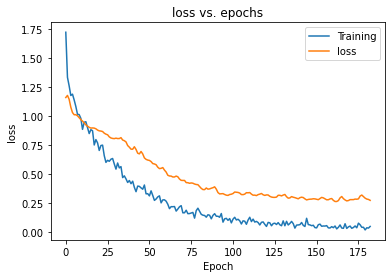

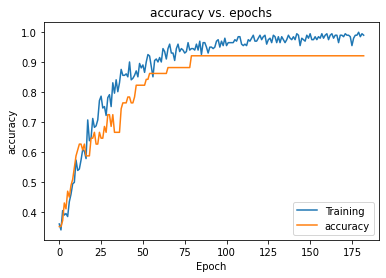

accuracy: 0.922


In [70]:
plot_result(history, res= 'loss')
plot_result(history, res= 'accuracy')
get_test_accuracy(model, X_test, Y_test)

In [71]:
# Save the model to disk
model.save('cnn_v1_saved_model')

Convert and save TF model to a tflite model

In [72]:
# Convert TF model to a tflite model
from tensorflow.keras.models import load_model

model_cnn_v1 = load_model('cnn_v1_saved_model')
converter = tf.lite.TFLiteConverter.from_keras_model(model_cnn_v1)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_model = converter.convert()

tflite_model_size = open("cnn_v1.tflite","wb").write(tflite_model)
print("Quantized model (DEFAULT) is {:,} bytes".format(tflite_model_size))

Quantized model (DEFAULT) is 11,392 bytes
